In [1]:
import os
import shutil

if os.path.exists('/content/rock_scissor_paper/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/rock_scissor_paper/')
    print('/content/rock_scissor_paper/ is removed !!!')

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/가위바위보/YandG.zip','r') as target_file:
    target_file.extractall('/content/rock_scissor_paper/')

In [3]:
import os
from glob import glob

label_name_list = os.listdir('/content/rock_scissor_paper/')

print('total label nums = ', len(label_name_list))
print('==================================')
print(label_name_list)

total label nums =  3
['rock', 'scissor', 'paper']


# 작업폴더 생성

In [4]:
import os

if not os.path.exists('/content/modeling'):
    os.mkdir('/content/modeling')
    print('Modeling dir is created !')

Modeling dir is created !


# train 폴더로 copy

In [5]:
import shutil

src_root_dir = '/content/rock_scissor_paper/'
dst_root_dir = '/content/modeling/train'

if os.path.exists(dst_root_dir):
    os.rmdir(dst_root_dir)
    print(dst_root_dir + 'is deleted !')

shutil.copytree(src_root_dir, dst_root_dir)

'/content/modeling/train'

# test 폴더 생성 후 label 폴더 생성

In [6]:
import os

label_name_list = os.listdir('/content/modeling/train/')


if not os.path.exists('/content/modeling/test/'):
    os.mkdir('/content/modeling/test/')
    print('/content/modeling/test dir is created !')
    
    count = 0

    for label_name in label_name_list:
        os.mkdir('/content/modeling/test/' + label_name)
        count += 1

    print('train label count => ', count)

/content/modeling/test dir is created !
train label count =>  3


# train 데이터에서 test 데이터로 비율만큼 이동

In [7]:
import os
import shutil
import random
from glob import glob

ratio = 0.2

train_root_dir = '/content/modeling/train/'
test_root_dir = '/content/modeling/test/'

image_label_list = os.listdir(train_root_dir)

for label_name in image_label_list:
    
    train_image_list = glob(train_root_dir + label_name+'/*.jpg')

    print('========================================================================')
    print('total [%s] image file nums => [%s]'%(label_name, len(train_image_list)))
    
    split_num = int(ratio * len(train_image_list))

    print('split nums => ', split_num)

    test_image_list = train_image_list[0:split_num] 

    move_nums = 0

    for image_file in test_image_list:

        shutil.move(image_file, test_root_dir + label_name)
        
        move_nums += 1

    print('total move nums => ', move_nums)
    print('========================================================================')


total [rock] image file nums => [2202]
split nums =>  440
total move nums =>  440
total [scissor] image file nums => [2320]
split nums =>  464
total move nums =>  464
total [paper] image file nums => [2270]
split nums =>  454
total move nums =>  454


# 검증

In [8]:
src_root_dir = '/content/modeling/train'
dst_root_dir = '/content/modeling/test'

train_label_name_list = os.listdir(src_root_dir)
test_label_name_list = os.listdir(dst_root_dir)

train_label_name_list.sort()
test_label_name_list.sort()

if train_label_name_list != test_label_name_list:
  print('error !')
else:
  print(len(train_label_name_list),len(test_label_name_list))

for label_name in train_label_name_list:

  train_data_nums = len(os.listdir(os.path.join(src_root_dir,label_name)))
  test_data_nums = len(os.listdir(os.path.join(dst_root_dir,label_name)))

  print('[%s] | train => [%s], test => [%s], total => [%s]'%(label_name, train_data_nums, test_data_nums,train_data_nums+test_data_nums ))
  print('========================================================')

3 3
[paper] | train => [1816], test => [454], total => [2270]
[rock] | train => [1762], test => [440], total => [2202]
[scissor] | train => [1856], test => [464], total => [2320]


# Define Hyperparameter 

In [31]:
IMG_WIDTH = 112
IMG_HEIGHT = 112
BATCH_SIZE = 32

In [32]:
train_dir = '/content/modeling/train'
test_dir = '/content/modeling/test'

# Image Data Generator 정의

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [34]:
train_data = train_data_gen.flow_from_directory(directory=train_dir,
                                  batch_size=BATCH_SIZE,
                                  color_mode='rgb',
                                  shuffle=True,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  class_mode='sparse')
test_data = test_data_gen.flow_from_directory(directory=test_dir,
                                  batch_size=BATCH_SIZE,
                                  color_mode='rgb',
                                  shuffle=True,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  class_mode='sparse')

print('==========train==========')
print(train_data.class_indices)
print(train_data.num_classes)
print(len(train_data.classes))

print('==========test==========')
print(test_data.class_indices)
print(test_data.num_classes)
print(len(test_data.classes))

Found 5434 images belonging to 3 classes.
Found 1358 images belonging to 3 classes.
==========train==========
{'paper': 0, 'rock': 1, 'scissor': 2}
3
5434
==========test==========
{'paper': 0, 'rock': 1, 'scissor': 2}
3
1358


In [35]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, ResNet50, InceptionV3, Xception

# MobileNet

In [36]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 56, 56, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 56, 56, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 56, 56, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 56, 56, 32)       128       
 ation)                                         

In [60]:
model = Sequential()

model.add(mobilenet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(2e-5),
              metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2359552   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 5,589,187
Trainable params: 5,567,299
Non-trainable params: 21,888
_______________________________________

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './rps_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_data,
                 epochs=20,
                 validation_data=test_data)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/20
170/170 [==============================] - 53s 182ms/step - loss: 0.8192 - acc: 0.7118 - val_loss: 0.2796 - val_acc: 0.8814
Epoch 2/20
170/170 [==============================] - 30s 173ms/step - loss: 0.4054 - acc: 0.8515 - val_loss: 0.1616 - val_acc: 0.9477
Epoch 3/20
170/170 [==============================] - 29s 172ms/step - loss: 0.2828 - acc: 0.8958 - val_loss: 0.1157 - val_acc: 0.9602
Epoch 4/20
170/170 [==============================] - 29s 168ms/step - loss: 0.2520 - acc: 0.9098 - val_loss: 0.1057 - val_acc: 0.9683
Epoch 5/20
170/170 [==============================] - 30s 175ms/step - loss: 0.2153 - acc: 0.9201 - val_loss: 0.0845 - val_acc: 0.9750
Epoch 6/20
170/170 [==============================] - 30s 178ms/step - loss: 0.1752 - acc: 0.9336 - val_loss: 0.0653 - val_acc: 0.9816
Epoch 7/20
170/170 [==============================] - 30s 177ms/step - loss: 0.1590 - acc: 0.9404 - val_loss: 0.0592 - val_acc: 0.9809
Epoch 8/20
170/170 [==============================] - 3

## Accuracy

In [62]:
model.evaluate(test_data)

43/43 [==============================] - 2s 41ms/step - loss: 0.0149 - acc: 0.9948


[0.014946307055652142, 0.9948453903198242]

## Graph

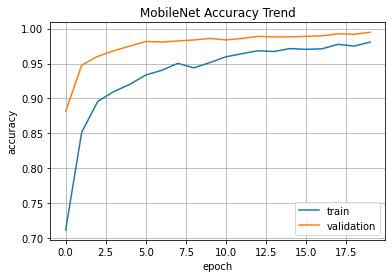

In [63]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('MobileNet Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

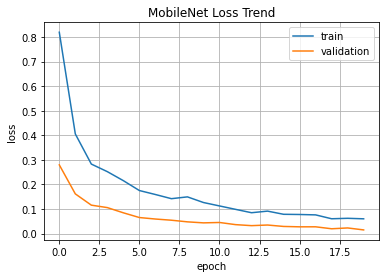

In [64]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('MobileNet Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [83]:
# model.save('./MobileNet_112_acc_0.996_Colab.h5')

In [74]:
# mv /content/MobileNet_112_acc_0.996_Colab.h5 /content/drive/MyDrive/Git/rock_paper_scissors_classification/model

# Sample Data Generator 정의

In [79]:
sample_dir = '/content/sample2/rps-test-set'

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sample_data_gen = ImageDataGenerator(rescale=1./255)

In [81]:
sample_data = sample_data_gen.flow_from_directory(directory=sample_dir,
                                  batch_size=BATCH_SIZE,
                                  color_mode='rgb',
                                  shuffle=True,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  class_mode='sparse')

print('==========sample==========')
print(sample_data.class_indices)
print(sample_data.num_classes)
print(len(sample_data.classes))


Found 372 images belonging to 3 classes.
==========sample==========
{'paper': 0, 'rock': 1, 'scissors': 2}
3
372
